In [1]:
options(jupyter.plot_mimetypes = c("image/png"))

suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(ggpattern))

## For loading Arial font for publication
# library(extrafont)

# font_import(pattern = "Arial", prompt = FALSE)
# loadfonts(device = "pdf")

Warning message:
“package ‘ggpattern’ was built under R version 4.4.3”


In [2]:
# Read the master df
master_csv <- "resources/recessive.cross_studies_comparison.csv"
master_df <- read.csv(file = master_csv, header = TRUE, sep = ",", stringsAsFactors = FALSE)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_rect_pattern()`).”


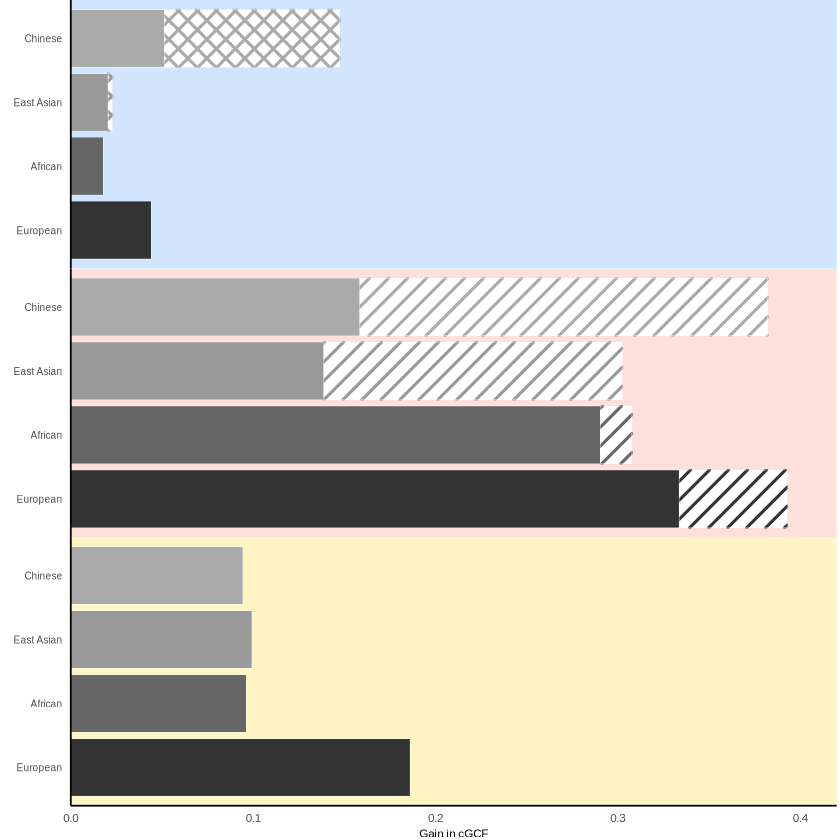

In [3]:
# Define population-specific colors in grayscale
pop_colors <- c(
  "European" = "#333333",    # Dark gray
  "African" = "#666666",     # Medium gray
  "East Asian" = "#999999",  # Light gray
  "Chinese" = "#AAAAAA"      # Very light gray
)

# Custom colors for the tier backgrounds - slightly darker for better contrast
tier_fill_colors <- c(
  "Tier 1" = "#d1e5ff", # Light blue background (darker than before)
  "Tier 2" = "#ffe0db", # Light red background (darker than before)
  "Tier 3" = "#fff4c4"  # Light yellow background (darker than before)
)
acmg_t1_2 <- master_df %>%
  filter(acmg_tier_hkgi == "tier_1" | acmg_tier_hkgi == "tier_2") %>% 
  select(gene, is_xlinked, acmg_tier_hkgi, carrier_rate_hkgi) %>% 
  filter(carrier_rate_hkgi > 0.001) %>% 
  mutate(acmg_tier_hkgi = factor(acmg_tier_hkgi, levels = c("tier_1", "tier_2"))) %>% 
  arrange(acmg_tier_hkgi, desc(carrier_rate_hkgi))
acmg_t1_2$gene <- factor(acmg_t1_2$gene, levels = acmg_t1_2$gene)
acmg_t1_2$log_carrier_rate_hkgi <- exp(acmg_t1_2$carrier_rate_hkgi)

acmg_t3 <- master_df %>%
  filter(acmg_tier_hkgi == "tier_3") %>%
  select(gene, is_xlinked, acmg_tier_hkgi, carrier_rate_hkgi) %>% 
  filter(carrier_rate_hkgi > 0.001) %>% 
  arrange(acmg_tier_hkgi, desc(carrier_rate_hkgi))
acmg_t3$gene <- factor(acmg_t3$gene, levels = acmg_t3$gene)

# HKGI
hkgi_cGCF_df <- master_df %>% 
    select(gene, acmg_tier_hkgi, carrier_rate_hkgi) %>% 
    rename(acmg_tier = acmg_tier_hkgi) %>% 
    mutate(acmg_tier = ifelse(gene == "GJB2" & acmg_tier == "tier_2", "tier_2_GJB2", acmg_tier)) %>% 
    mutate(acmg_tier = ifelse(gene == "HBA1/HBA2" & acmg_tier == "tier_1", "tier_1_HBA1/2", acmg_tier))

# Group by acmg_tier_hkgi and sum up carrier_rate_hkgi
hkgi_grouped <- hkgi_cGCF_df %>%
  group_by(acmg_tier) %>%
  summarise(hkgi = sum(carrier_rate_hkgi, na.rm = TRUE))

# gnomAD_NFE
NFE_cGCF_df <- master_df %>% 
    select(gene, acmg_tier_gnomAD.NFE, carrier_rate_gnomAD.NFE) %>%
    rename(acmg_tier = acmg_tier_gnomAD.NFE) %>% 
    mutate(acmg_tier = ifelse(gene == "GJB2" & acmg_tier == "tier_2", "tier_2_GJB2", acmg_tier)) %>% 
    mutate(acmg_tier = ifelse(gene == "HBA1/HBA2" & acmg_tier == "tier_1", "tier_1_HBA1/2", acmg_tier))

# Group by acmg_tier_hkgi and sum up carrier_rate_hkgi
NFE_grouped <- NFE_cGCF_df %>%
  group_by(acmg_tier) %>%
  summarise(gnomAD.NFE = sum(carrier_rate_gnomAD.NFE, na.rm = TRUE))

# gnomAD_AFR
AFR_cGCF_df <- master_df %>% 
    select(gene, acmg_tier_gnomAD.AFR, carrier_rate_gnomAD.AFR) %>%
    rename(acmg_tier = acmg_tier_gnomAD.AFR) %>% 
    mutate(acmg_tier = ifelse(gene == "GJB2" & acmg_tier == "tier_2", "tier_2_GJB2", acmg_tier)) %>% 
    mutate(acmg_tier = ifelse(gene == "HBA1/HBA2" & acmg_tier == "tier_1", "tier_1_HBA1/2", acmg_tier))

# Group by acmg_tier_hkgi and sum up carrier_rate_hkgi
AFR_grouped <- AFR_cGCF_df %>%
  group_by(acmg_tier) %>%
  summarise(gnomAD.AFR = sum(carrier_rate_gnomAD.AFR, na.rm = TRUE))

# gnomAD_EAS
EAS_cGCF_df <- master_df %>% 
    select(gene, acmg_tier_gnomAD.EAS, carrier_rate_gnomAD.EAS) %>%
    rename(acmg_tier = acmg_tier_gnomAD.EAS) %>% 
    mutate(acmg_tier = ifelse(gene == "GJB2" & acmg_tier == "tier_2", "tier_2_GJB2", acmg_tier)) %>% 
    mutate(acmg_tier = ifelse(gene == "HBA1/HBA2" & acmg_tier == "tier_1", "tier_1_HBA1/2", acmg_tier))

# Group by acmg_tier_hkgi and sum up carrier_rate_hkgi
EAS_grouped <- EAS_cGCF_df %>%
  group_by(acmg_tier) %>%
  summarise(gnomAD.EAS = sum(carrier_rate_gnomAD.EAS, na.rm = TRUE))

acmg_tier_df <- NFE_grouped %>% 
    full_join(AFR_grouped, by = "acmg_tier") %>%
    full_join(EAS_grouped, by = "acmg_tier") %>%
    full_join(hkgi_grouped, by = "acmg_tier") %>% 
    filter(acmg_tier != "tier_4")

# Combine tier_2 and tier_2_GJB2 into a single group but keep them separate for stacking
acmg_tier_df <- acmg_tier_df %>%
  mutate(acmg_tier_group = ifelse(acmg_tier %in% c("tier_2", "tier_2_GJB2"), "tier_2_combined", acmg_tier)) %>% 
  mutate(acmg_tier_group = ifelse(acmg_tier_group %in% c("tier_1", "tier_1_HBA1/2"), "tier_1_combined", acmg_tier_group))

# Create a better label for facet titles
acmg_tier_df <- acmg_tier_df %>%
  mutate(tier_label = case_when(
    acmg_tier_group == "tier_1_combined" ~ "Tier 1",
    acmg_tier_group == "tier_2_combined" ~ "Tier 2",
    acmg_tier_group == "tier_3" ~ "Tier 3",
    TRUE ~ as.character(acmg_tier_group)
  ))

# Reshape the data to long format for plotting
acmg_tier_long <- acmg_tier_df %>%
  pivot_longer(
    cols = c(gnomAD.NFE, gnomAD.AFR, gnomAD.EAS, hkgi),
    names_to = "Population",
    values_to = "Value"
  ) %>%
  mutate(
    Population = case_when(
      Population == "gnomAD.NFE" ~ "European",
      Population == "gnomAD.AFR" ~ "African",
      Population == "gnomAD.EAS" ~ "East Asian",
      Population == "hkgi" ~ "Chinese",
      TRUE ~ Population  # Keep other values unchanged
    )
  )

# Split the data into regular tiers and special tiers
regular_tiers <- acmg_tier_long %>%
  filter(!acmg_tier %in% c("tier_1_HBA1/2", "tier_2_GJB2"))

special_tiers <- acmg_tier_long %>%
  filter(acmg_tier %in% c("tier_1_HBA1/2", "tier_2_GJB2"))

# Calculate the sum of regular tier values for each Population and acmg_tier_group
regular_tier_sums <- regular_tiers %>%
  group_by(Population, acmg_tier_group, tier_label) %>%
  summarise(total_value = sum(Value, na.rm = TRUE), .groups = "drop")

# Join the sums to special tiers to properly position them
special_tiers <- special_tiers %>%
  left_join(regular_tier_sums, by = c("Population", "acmg_tier_group", "tier_label")) %>%
  mutate(
    ymin = total_value,  # Start at the sum of regular tiers
    ymax = total_value + Value  # End at sum + special tier value
  )

# Ensure the order of tiers and populations
regular_tiers$acmg_tier <- factor(regular_tiers$acmg_tier, levels = c("tier_1", "tier_2", "tier_3", "tier_4"))
regular_tiers$acmg_tier_group <- factor(regular_tiers$acmg_tier_group, levels = c("tier_1_combined", "tier_2_combined", "tier_3", "tier_4"))
regular_tiers$tier_label <- factor(regular_tiers$tier_label, levels = c("Tier 1", "Tier 2", "Tier 3", "Tier 4"))
regular_tiers$Population <- factor(regular_tiers$Population, levels = c("European", "African", "East Asian", "Chinese"))

special_tiers$acmg_tier <- factor(special_tiers$acmg_tier, levels = c("tier_1_HBA1/2", "tier_2_GJB2"))
special_tiers$acmg_tier_group <- factor(special_tiers$acmg_tier_group, levels = c("tier_1_combined", "tier_2_combined"))
special_tiers$tier_label <- factor(special_tiers$tier_label, levels = c("Tier 1", "Tier 2", "Tier 3", "Tier 4"))
special_tiers$Population <- factor(special_tiers$Population, levels = c("European", "African", "East Asian", "Chinese"))

# Final plot with properly colored backgrounds and horizontal orientation
grouped_stacked_bar <- ggplot() +
  # Add panel background colors first
  geom_rect(
    data = data.frame(
      tier_label = factor(names(tier_fill_colors), levels = names(tier_fill_colors))
    ),
    aes(
      xmin = -Inf, xmax = Inf,
      ymin = -Inf, ymax = Inf,
      fill = tier_label
    ),
    alpha = 1
  ) +
  # Regular tiers with solid colors
  geom_bar(
    data = regular_tiers,
    aes(x = Population, y = Value, fill = Population),
    stat = "identity", 
    position = position_stack(reverse = TRUE),
    color = "white",
    linewidth = 0.1
  ) +
  # Special tiers with stripe patterns
  geom_rect_pattern(
    data = special_tiers,
    aes(
      xmin = as.numeric(Population) - 0.45,
      xmax = as.numeric(Population) + 0.45,
      ymin = ymin,
      ymax = ymax,
      pattern_color = Population,
      pattern = acmg_tier
    ),
    linejoin = "mitre",
    fill = "white",
    pattern_fill = "white",
    pattern_angle = 45,
    pattern_density = 0.1,
    pattern_spacing = 0.05,
    pattern_key_scale_factor = 0.5,
    color = "white",
    linewidth = 0.1
  ) +
  # Add pattern scale with legend showing both patterns
  scale_pattern_manual(
    values = c(
      "tier_1_HBA1/2" = "crosshatch",
      "tier_2_GJB2" = "stripe"
    ),
    labels = c(
      "tier_1_HBA1/2" = "HBA1/2",
      "tier_2_GJB2" = "GJB2"
    ),
    name = "Special genes"
  ) +
  facet_wrap(~ tier_label, ncol = 1, strip.position = "top") +
  coord_flip() +
  theme_minimal() +
  # theme_minimal(base_family = "Arial") +
  labs(
    title = "",
    x = "",
    y = "Gain in cGCF",
    fill = "Population"
  ) + 
  scale_y_continuous(
    breaks = seq(0, .42, by = 0.1),
    limits = c(0, .42), 
    expand = c(0, 0)
  ) +
  scale_fill_manual(
    values = c(pop_colors, tier_fill_colors),
    breaks = names(pop_colors),
    name = "Population"
  ) +
  scale_pattern_color_manual(
    values = pop_colors,
    guide = "none"  # Hide this legend since pattern colors follow population colors
  ) +
  theme(
    axis.text.y = element_text(size = 6, hjust = 1),
    axis.text.x = element_text(size = 7),
    plot.title = element_blank(),
    axis.title.y = element_text(size = 6),
    axis.title.x = element_text(size = 7),
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"), 
    legend.position = "none",
    legend.title = element_text(size = 6),
    legend.text = element_text(size = 5),
    legend.key.size = unit(2.5, "mm"),
    legend.key.width = unit(2.5, "mm"),
    legend.key.height = unit(2.5, "mm"),
    legend.box = "vertical",  # Stack legends vertically
    strip.placement = "outside",
    strip.text = element_blank(),
    strip.background = element_rect(fill = "white", color = NA),
    panel.spacing = unit(0, "lines"),
    plot.margin = margin(0, 2, 0, 0, unit = "pt"),
    strip.switch.pad.grid = unit(0, "pt"),
    strip.switch.pad.wrap = unit(0, "pt")
  )

# Display the plot
grouped_stacked_bar

# # Save the plot with adjusted dimensions for vertical layout
# ggsave(
#   filename = "results/secondary/recessive/main/tier_cGCF_gained.pdf",
#   plot = grouped_stacked_bar,
#   width = 50, height = 56,  # Adjusted dimensions for vertical layout
#   units = "mm", dpi = 600
# )